# 

Note: the solution for heat transfer does not consider heat exchange with the aquitard.


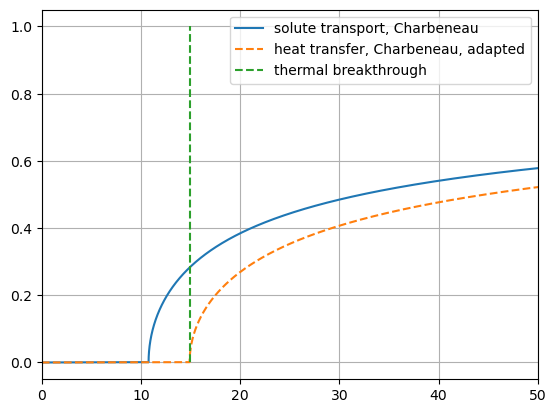

Der Einflussbereich im Aquitard beträgt 52.07m


In [1]:
import numpy as np
import matplotlib.pyplot as plt

diameter = 4000     # Durchmesser Gebiet

tmax = 50

a = 450             # Halber Abstand der Bohrungen
Q = 0.03            # Injektionsrate (m³/s)
dwell = 0.3         # Durchmesser der Bohrung
#dwell = 50

Tin = 1.0           # Normalized injection temperature
Tref = 0.0          # Normalized reference temperature = normalized initial reservoir temperature


lc = diameter / 10  #



M = 30             # Mächtigkeit des Aquifers (m)
dM = 1             # Abstand des Brunnens zum Aquifer
phi = 0.4          # Porosität des Aquifers
rho_S = 1900         # Dichte 
c_S = 850             # Wärmekapazität
lambda_S = 3.0      # Wärmeleitfähigkeit

# Fluid
rho_F = 1500
c_F = 4200

a2s = 365*24*3600   # Umrechnung von Sekunden in Jahre

rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
L = np.sqrt(2*tmax*a2s*lambda_S/rho_A_c_A)
L0 = 0.01

# Analytical solution


# Durchbruchszeit bestimmen
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) /a2s

F = np.linspace(1e-20, 1, 1000)
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / a2s
tau2 = G*tf/phi

print("Note: the solution for heat transfer does not consider heat exchange with the aquitard.")

plt.plot(tf, F, label="solute transport, Charbeneau")
plt.plot(tau2, F, '--', label="heat transfer, Charbeneau, adapted")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()




print(f"Der Einflussbereich im Aquitard beträgt {L:.2f}m")

Looking in indexes: https://gmsh.info/python-packages-dev-nox
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 76.3 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: gmsh
    Found existing installation: gmsh 5.0.0.dev1+nox
    Uninstalling gmsh-5.0.0.dev1+nox:
      Successfully uninstalled gmsh-5.0.0.dev1+nox
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ogstools 0.7.0 requires watchdog>=6.0.0, which is not installed.


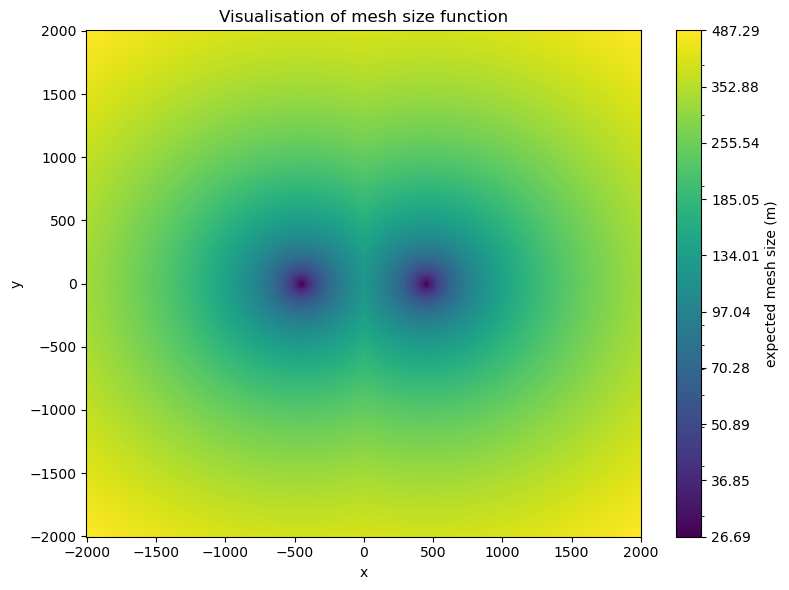

In [ ]:
#Install gmsh without X11 dependency
!pip uninstall -y pygmsh 
!pip uninstall -y gmsh
!pip install -i https://gmsh.info/python-packages-dev-nox --force-reinstall --no-cache-dir gmsh==4.15.0.dev1+nox
# Fixed gmsh version due to problems of gmsh 5.0.0 with pygmsh
!pip install pygmsh 

import pygmsh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def field(x, y, d):
    return 0.4*np.power(np.sqrt((x+d)*(x+d) + y*y), 0.9)+dwell/2

def doublet(x, y, d):
    return np.minimum(field(x, y, -d), field(x, y, d))

# Parameter
x_range = np.linspace(-diameter/2, diameter/2, 500)
y_range = np.linspace(-diameter/2, diameter/2, 500)
X, Y = np.meshgrid(x_range, y_range)

# Feld berechnen
Z = doublet(X, Y, d=a)

# Wertebereich festlegen
z_min = np.min(Z)
z_max = np.max(Z)

# Plot mit logarithmischer Farbskala
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', norm=LogNorm(vmin=z_min, vmax=z_max), cmap='viridis')
cbar = plt.colorbar(label='expected mesh size (m)')
plt.title('Visualisation of mesh size function')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

ticks = np.geomspace(z_min, z_max, 10)  # Beispiel: min, mittel, max
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])


plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean difference operation.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/pygmsh/occ/geometry.py:221: UserWarning: Specified mesh size for <pygmsh Disk object, ID 2> discarded in Boolean difference operation.
  warnings.warn(


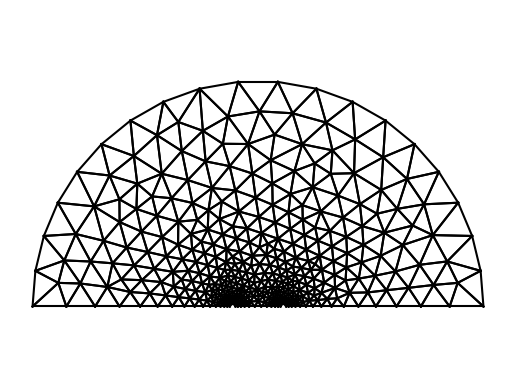

In [3]:
with pygmsh.occ.Geometry() as geom:

    #Disk as base geometry
    disk_domain = geom.add_disk([0.0, 0.0], diameter, mesh_size=lc)

    #Add injection and extraction well as points in the geometry
    for b in [-a, a]:
        #p = geom.add_point([b, 0, 0], mesh_size=0.1)
        #geom.boolean_fragments([disk], [p], delete_other=False)

        disk_well = geom.add_disk([b, 0.0], dwell, mesh_size=dwell/2)
        geom.boolean_difference(disk_domain, disk_well)

    #
    rectangle = [geom.add_rectangle([-diameter, -diameter, 0.0], 2*diameter, diameter)]
    geom.boolean_difference(disk_domain, rectangle)

    geom.set_mesh_size_callback(
        lambda dim, tag, x, y, z, lc: doublet(x,y,a)
    )

    mesh = geom.generate_mesh()

triangles = mesh.cells_dict["triangle"]
points = mesh.points

pts = points[:, :2]
for e in triangles:
    for idx in [[0, 1], [1, 2], [2, 0]]:
        X = pts[e[idx]]
        plt.plot(X[:, 0], X[:, 1], "-k")

plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
plt.show()

mesh.write("domain.vtu")

In [4]:
#!pip install pyvista[jupyter]
import pyvista as pv
from geo import layersfromsurf

#pv.set_jupyter_backend('trame')

scenario = 1


if scenario == 1:
    nAquifer = 1

elif scenario == 2:
    nAquifer = 3
    nAquitard = 5

    phiAquitard = 0.1
    KAquitard = 1e-14

KAquifer = 1e-10


for file in ["domain.vtu"]:

    mesh2d = pv.read(file)

    if scenario == 1:
        thickness = np.array([M])

    elif scenario == 2:
        pAquitard = np.geomspace(L0, L, nAquitard+2)
        dAquitard = np.diff(pAquitard)
        thickness = np.hstack((np.flip(dAquitard), 
                            np.array([dM]),
                            np.array([(M-dM)/2/nAquifer] * nAquifer)))

    mesh3d = layersfromsurf(mesh2d, thickness)

    mesh3d["porosity"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["permeability"] = np.repeat(KAquifer, mesh3d.number_of_cells)

    if scenario == 2:
        mesh3d["porosity"][mesh3d["Layer"] <= nAquitard] = phiAquitard
        mesh3d["permeability"][mesh3d["Layer"] <= nAquitard] = KAquifer 

    #mesh3d["Porosity"][mesh3d["Layer"] > (nAquitard+nAquifer)] = phiAquitard
    #mesh3d["Permeability"][mesh3d["Layer"] > (nAquitard+nAquifer)] = KAquitard

    # Add info for OGS
    mesh3d.point_data["bulk_node_ids"] = np.arange(0, mesh3d.n_points, dtype=np.uint64)
    mesh3d.cell_data["bulk_element_ids"] = np.arange(0, mesh3d.n_cells, dtype=np.uint64)

    mesh3d.save(file)


#mesh3d.plot(scalars="Layer", show_edges=True, cmap="viridis")
#mesh3d.plot(scalars="porosity", show_edges=True, cmap="Pastel1")

In [5]:
surf = mesh3d.extract_surface()
cell_normals = surf.cell_normals

# Define surface normals and names
n_vectors = [[0, 0, -1], [0, 0, 1], [0, 1, 0]]
surf_names = ["bottom", "top", "profile"]
eps = 1e-8

#all_selected = np.array([], dtype=int)
all_selected = np.array([])

# Select surface cells based on normal vectors
for n, name in zip(n_vectors, surf_names):
    l2 = np.linalg.norm(cell_normals - n, axis=1)
    ids = np.where(l2 < eps)[0]

    if ids.size > 0:
        subset = surf.extract_cells(ids)
        subset.save(f"{name}.vtu")
        all_selected = np.concatenate((all_selected, ids))
        print(f"{name}: {ids.size} cells found...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Identify unselected surface cells
unselected_ids = np.setdiff1d(np.arange(surf.n_cells), all_selected)
unselected = surf.extract_cells(unselected_ids)
centers = unselected.cell_centers().points[:,:2] #ignore z-value

# Define classification centers and names
radius = 5*dwell
targets = [[b, 0], [-b, 0]]
names = ["injection", "extraction"]

classified_ids = np.array([], dtype=int)

# Classify injection and extraction cells by distance
for pt, name in zip(targets, names):
    dist = np.linalg.norm(centers - np.array(pt), axis=1)
    ids = np.where(dist < radius)[0]

    if ids.size > 0:
        subset = unselected.extract_cells(ids)
        subset.save(f"{name}.vtu")
        classified_ids = np.concatenate((classified_ids, ids))
        print(f"{name}: {ids.size} cells found...")
    else:
        print(f"Warning: {name} mesh has no cells...")

# Remaining cells are boundary
boundary_ids = np.setdiff1d(np.arange(unselected.n_cells), classified_ids)
if boundary_ids.size > 0:
    unselected.extract_cells(boundary_ids).save("boundary.vtu")
    print(f"boundary: {boundary_ids.size} cells found...")
else:
    print("Warning: boundary mesh has no cells...")     

bottom: 718 cells found...
top: 718 cells found...
profile: 43 cells found...
injection: 4 cells found...
extraction: 4 cells found...
boundary: 19 cells found...


In [6]:
import ogstools as ogs

mesh2d = pv.read("injection.vtu")
#mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The discretized surface area is: {surface_area:.2f} m²")
print(f"The real surface area is: {dwell*np.pi*M:.2f} m²")

# Calculate inflow rates at injection well
qVin = Q / surface_area / 2                  # Pressure
qTin = rho_F * c_F * qVin * (Tin - Tref)    # Temperature

# Define injection rate for source term at injection well (pressure)
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="injection_rate", value=qVin)
prj.replace_parameter_value(name="heatinjection", value=qTin)
prj.write_input() 

The discretized surface area is: 3708.20 m²
The real surface area is: 4712.39 m²


In [7]:
mesh2d = pv.read("extraction.vtu")
#mesh2d.plot(show_edges=True, cmap="Pastel1")

# Calculate surface area
surface_area = mesh2d.area
print(f"The surface area is: {surface_area:.2f} m²")

# Calculate outflow rates at extraction well
qVout = - qVin
qTout = 0

# Write parameter for Python sink term for temperatur at extraction well
with open("parameter.py", "w", encoding="utf-8") as file:
    file.write(f"Area = {surface_area}")

# Define extraction_rate for sink term (pressure) at extraction well
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="extraction_rate", value=qVout)
prj.write_input()

The surface area is: 3708.20 m²


In [8]:
# Add bulk_node_ids with OGSTools

!identifySubdomains -m domain.vtu -- extraction.vtu
!identifySubdomains -m domain.vtu -- injection.vtu
!identifySubdomains -m domain.vtu -- top.vtu
!identifySubdomains -m domain.vtu -- bottom.vtu
!identifySubdomains -m domain.vtu -- boundary.vtu
!identifySubdomains -m domain.vtu -- profile.vtu

[2025-11-04 16:45:17.178] [ogs] [info] Mesh reading time: 0.0036408 s
[2025-11-04 16:45:17.179] [ogs] [info] MeshNodeSearcher construction time: 0.000186408 s
[2025-11-04 16:45:17.179] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.6951e-05 s
[2025-11-04 16:45:17.179] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'extraction' and it is equal to the newly computed values.
[2025-11-04 16:45:17.182] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00330287 s
[2025-11-04 16:45:17.182] [ogs] [info] There is already a 'bulk_element_ids' property present in the subdomain mesh 'extraction' and it is equal to the newly computed values.
[2025-11-04 16:45:17.182] [ogs] [info] identifySubdomains time: 0.00337773 s
[2025-11-04 16:45:17.184] [ogs] [info] writing time: 0.00209561 s
[2025-11-04 16:45:17.184] [ogs] [info] Entire run time: 0.00958157 s
[2025-11-04 16:45:17.385] [ogs] [info] Mesh reading time: 0.0

In [9]:
!NodeReordering -i domain.vtu -o domain.vtu
!checkMesh -v domain.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v injection.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v extraction.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v boundary.vtu

[2025-11-04 16:45:18.384] [ogs] [info] Reordering nodes... 
[2025-11-04 16:45:18.384] [ogs] [info] Corrected 718 elements.
[2025-11-04 16:45:18.387] [ogs] [info] VTU file written.
[2025-11-04 16:45:18.572] [ogs] [info] Memory size: 0 MiB
[2025-11-04 16:45:18.572] [ogs] [info] Time for reading: 0.00425674 s
[2025-11-04 16:45:18.572] [ogs] [info] Axis aligned bounding box: 	x [-4000, 4000) (extent 8000)
	y [-1.44023e-12, 3984.48) (extent 3984.48)
	z [0, 30) (extent 30)
[2025-11-04 16:45:18.572] [ogs] [info] Min/max edge lengths: [29.9665, 748.905]
[2025-11-04 16:45:18.572] [ogs] [info] Number of elements in the mesh:
[2025-11-04 16:45:18.572] [ogs] [info] 	Prisms: 718
[2025-11-04 16:45:18.572] [ogs] [info] Mesh Quality Control:
[2025-11-04 16:45:18.572] [ogs] [info] Looking for unused nodes...
[2025-11-04 16:45:18.572] [ogs] [info] Found 0 potentially collapsible nodes.
[2025-11-04 16:45:18.573] [ogs] [info] Testing mesh element geometry:
[2025-11-04 16:45:18.573] [ogs] [info] No errors 

In [10]:
import ogstools as ogs

# Simulate problem with TwoPhaseFlowPP and TH2M
prj_file = r"doublet.prj"

prj = ogs.Project(input_file=prj_file, output_file=prj_file)
#prj.write_input()        
prj.run_model()

Project file written to output.
Simulation: doublet.prj
Status: finished successfully.
Execution took 346.946977853775 s


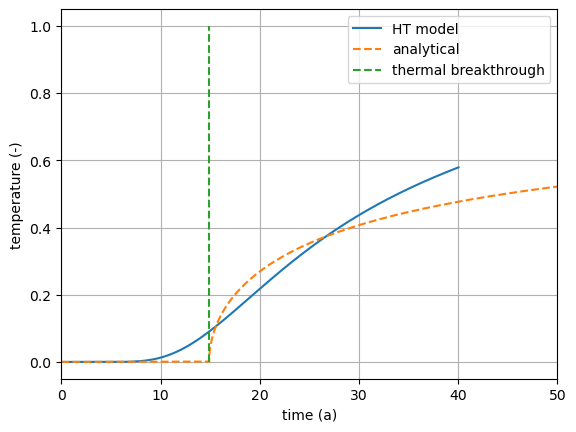

In [11]:
import pyvista as pv
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def parse_pvd(pvd_file):
    # XML einlesen und parsen
    tree = ET.parse(pvd_file)
    root = tree.getroot()

    # Listen für timestep und file
    timesteps = []
    files = []

    # Alle DataSet-Elemente durchgehen
    for dataset in root.find("Collection").findall("DataSet"):
        timesteps.append(float(dataset.attrib["timestep"]))
        files.append(dataset.attrib["file"])

    return timesteps, files


def mean_over_time(pvd_file, domain_vtu, roi_vtu, field):

    output = list()
    
    timesteps, files = parse_pvd(pvd_file)

    # ROI-Datei laden
    roi_mesh = pv.read(roi_vtu)
    roi_ids = roi_mesh.point_data["bulk_node_ids"]

    # Domain laden
    domain_mesh = pv.read(domain_vtu)
    domain_ids = domain_mesh.point_data["bulk_node_ids"]

    # Maske: Welche Punkte im Ziel-Mesh gehören zur ROI?
    mask = np.isin(domain_ids, roi_ids)

    for file in files:

        # Ziel-VTU-Datei laden
        target_mesh = pv.read(file)
        
        # Temperaturwerte an diesen Punkten extrahieren
        roi_field = target_mesh.point_data[field][mask]
        
        # Mittelwert berechnen
        mean_field = np.mean(roi_field)

        output.append(mean_field)

    return np.array(timesteps), np.array(output)

time, temperature = mean_over_time("geothermal_doublet.pvd", "domain.vtu", "extraction.vtu", "temperature")

seconds_per_year = 60*60*24*365

plt.plot(time/seconds_per_year, temperature, label="HT model")
plt.plot(tau2, F, '--', label="analytical")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")
plt.xlabel("time (a)")
plt.ylabel("temperature (-)")
plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()